# Extract, calibrate & analyze long-slit spectrum

In [1]:
__main__ = 'EasySpectrum'
__author__ = 'Pascal Louis <plouis35@gmail.com>'
__version__ = '0.2'
__keywords__ = ['astronomy', 'spectroscopy', 'astropy', 'specutils', 'specreduce', 'matplotlib']
#import sys, numpy, matplotlib
#print('Python ' + sys.version)
#print('matplotlib ' + str(sys.modules['matplotlib'].__version__))
#print('numpy ' + str(sys.modules['numpy'].__version__))
#!jupyter --version


## Define target

In [145]:
### Observatory location
# CALC
#OBS_LATITUDE = 47.89
#OBS_LONGITUDE = -1.50

#OHP
OBS_LATITUDE = 43.931
OBS_LONGITUDE = 5.712

### Spectrum location
CAPTURE_DIR = '../../../CAPTURES/OHP2024/20240710/'
TARGET = 'chcyg'


## Imports libs

In [134]:
%matplotlib widget
import warnings, fnmatch, os
from time import gmtime, strftime
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, QTable
from astropy import units as u
from astropy.nddata import CCDData, StdDevUncertainty
from astropy.stats import mad_std
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning

from ccdproc import Combiner, combine, subtract_bias, subtract_dark, flat_correct
from ccdproc import trim_image, Combiner, ccd_process, cosmicray_median

from align_combine import align_and_combine

#warnings.simplefilter('ignore', category=AstropyWarning)
#warnings.simplefilter('ignore', UserWarning)


## Create logger

In [135]:
import sys
import logging

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger('notebook')

## Create spectrum

### Extract science spectrum

In [136]:
### run if spectra free of cosmics is to be used 
#master_science = sci_cleaned.data

2024-07-25 21:42:58 [INFO] - extracting science spectra...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-07-25 21:42:58 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
2024-07-25 21:42:58 [INFO] - using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-07-25 21:42:58 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Text(87.59722222222221, 0.5, 'ADU')

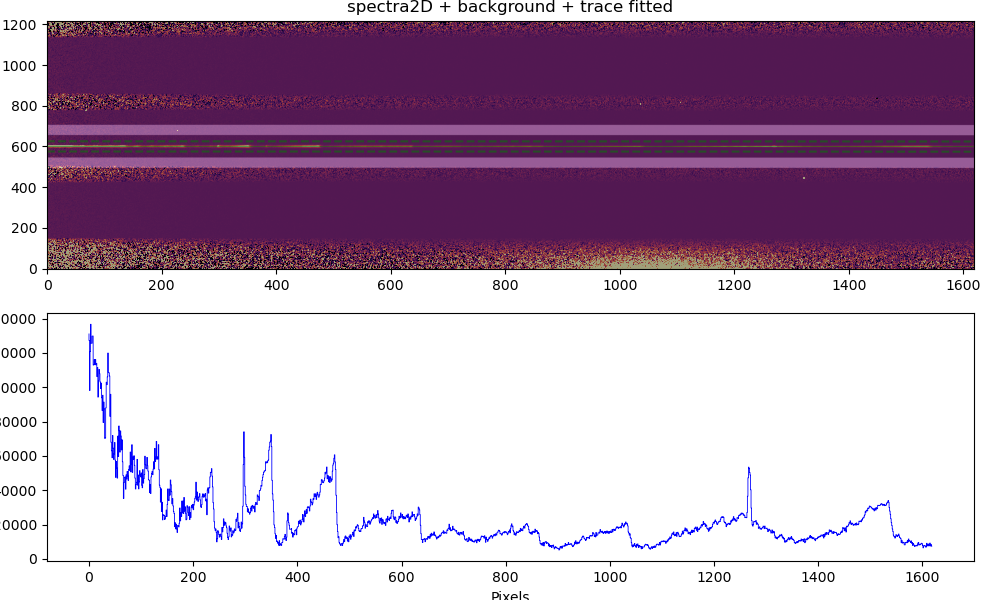

In [151]:
from astropy.modeling import models
from specreduce import tracing, background, extract

logger.info('extracting science spectra...')

master_science = CCDData.read(CAPTURE_DIR + TARGET + '-reduced.fit', unit = u.adu)
master_science_cosmic = CCDData.read(CAPTURE_DIR + TARGET + '-reduced-cosmics' + '.fit', unit = u.adu)
master_calib = CCDData.read(CAPTURE_DIR + 'mastercalib.fit', unit = u.adu)

#sci_tr = tracing.FlatTrace(master_science, 407)
sci_tr = tracing.FitTrace(master_science,  bins = 64, trace_model=models.Polynomial1D(degree=2), peak_method = 'gaussian', window = 50) #, guess=605) #, guess=407)
#trace_model : one of Chebyshev1D, Legendre1D, Polynomial1D, or Spline1D
#peak_method : One of gaussian, centroid, or max. gaussian
bg = background.Background.two_sided(master_science, sci_tr, separation=80, width=50) 
extract = extract.BoxcarExtract(master_science - bg, sci_tr, width = 25)
sci_spectrum = extract()

cuts = (5, 95.0)
ax0, ax1 = plt.subplots(2, 1, figsize = (10,6))[1]
plt.tight_layout()

im = ax0.imshow(master_science, origin='lower', aspect='auto', cmap=plt.cm.magma)
ax0.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.3)
ax0.imshow(sci_tr.image.data, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
im.set_clim(np.percentile(master_science, cuts))
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace , color='g', linewidth = '0.3')
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.set_title('spectra2D + background + trace fitted')

ax1.step(sci_spectrum.spectral_axis , sci_spectrum.flux, color='b', linewidth = '0.6')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('ADU')


### Extract reference spectrum

2024-07-25 21:43:05 [INFO] - extracting neon spectrum...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-07-25 21:43:05 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


(0.0, 100000.0)

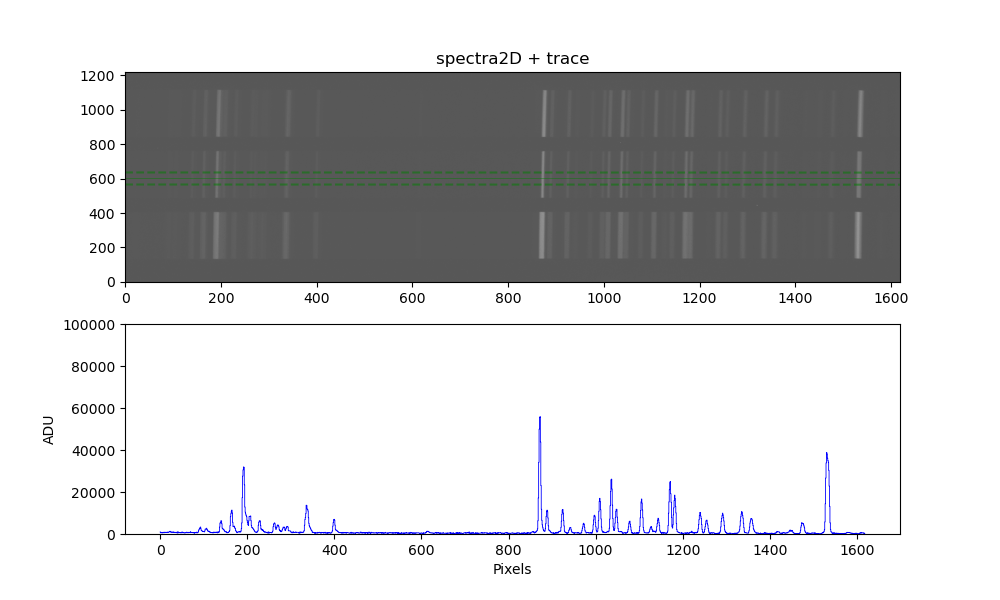

In [152]:
from astropy.modeling import models
from specreduce import tracing, background, extract

logger.info('extracting neon spectrum...')

neon_data = CCDData.read(CAPTURE_DIR + 'mastercalib.fit', unit = u.adu)

#specreduce.tracing.ArrayTrace(image: NDData, trace: ndarray)
#neon_tr = tracing.FlatTrace(neon_data,sci_tr.trace[int(sci_tr.shape[0] / 2.0)])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#neon_tr = tracing.ArrayTrace(neon_data, sci_tr.trace[int(sci_tr.shape[0] / 2.0)])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#bg = background.Background.two_sided(neon_data, sci_tr, separation=50, width=0) 
extract = extract.BoxcarExtract(neon_data , sci_tr, width = 35)
neon_spectrum = extract()

cuts = (5, 95.0)
ax0, ax1 = plt.subplots(2, 1, figsize = (10,6))[1]
#plt.tight_layout()

im = ax0.imshow(neon_data, origin='lower', aspect='auto', cmap=plt.cm.grey)
#ax0.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
ax0.imshow(sci_tr.image.data, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
im.set_clim(np.percentile(master_science, cuts))
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace , color='g', linewidth = '0.3')
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)

ax0.set_title('spectra2D + trace')

ax1.step(neon_spectrum.spectral_axis , neon_spectrum.flux, color='b', linewidth = '0.6')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('ADU')
ax1.set_ylim(0, 0.1e6)


### Calibrate reference spectrum

2024-07-25 21:43:09 [INFO] - calibrating neon spectrum...
residuals : [ 1.16686508 -1.86925785  0.39917267  0.67215864 -0.36893854] Angstrom
fitted  Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                c1                   c2         
         Angstrom       Angstrom / pix      Angstrom / pix2   
    ----------------- ------------------ ---------------------
    4343.458795871202 1.7036962037914818 3.257487791156155e-05


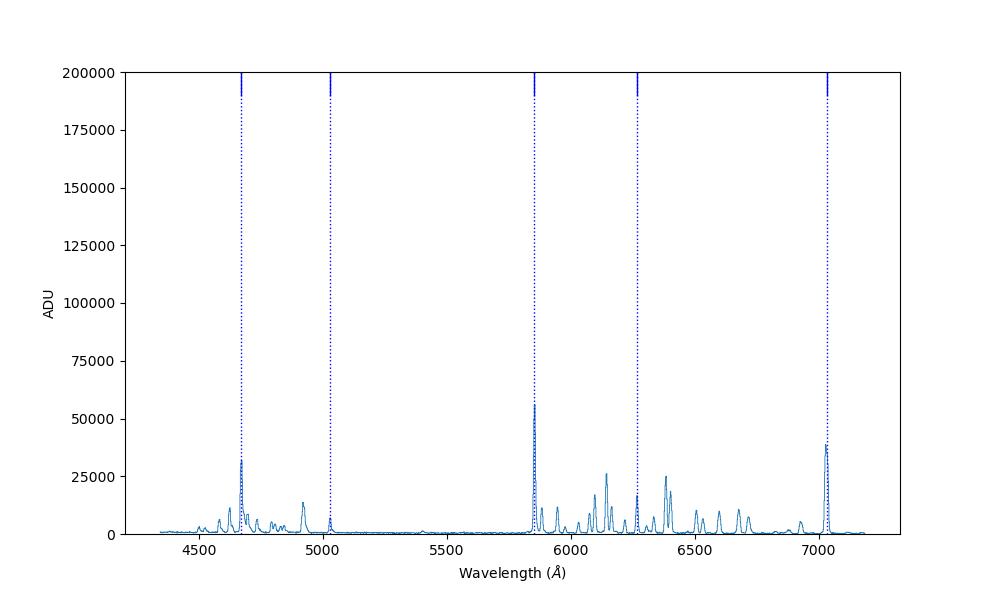

In [153]:
import astropy.units as u
from astropy.modeling import models, fitting
from specreduce import WavelengthCalibration1D

logger.info('calibrating neon spectrum...')

### alpy-600 + neon builtin
#pixels = [351, 589, 1045, 1403, 1885, 2073]*u.pix
#wavelength = [4200.67, 4764.87, 5852.49, 6677.28, 7272.94, 7635.11]*u.AA
#pixels =     [355,     1045,    1171     , 1284,   1406,      1535  , 1674  , 1840 ]*u.pix
#wavelength = [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]*u.AA
#wavelength_ = wavelength #= [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]

# Dados200 + Xenon lamp
pixels = [191, 400, 871, 1105, 1533]*u.pix
#pixels = [188, 396, 868, 1102, 1530]*u.pix
wavelength = [4671.22, 5028.28, 5852.49, 6266.49, 7031.41]*u.AA

### StarEx-2400
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA

### DADOS-200
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA

#line_list = QTable([pixels, wavelength], names=["pixel_center", "wavelength"])
#input_spectrum, matched_line_list=None, line_pixels=None, line_wavelengths=None, catalog=None, input_model=Linear1D(), fitter=None
cal = WavelengthCalibration1D(input_spectrum = neon_spectrum,
      #matched_line_list = line_list,
      line_wavelengths = wavelength,
      line_pixels = pixels,
      input_model = models.Polynomial1D(degree = 2),
      #fitter = fitting.LMLSQFitter()
      fitter = fitting.LinearLSQFitter()
     )
print('residuals :', cal.residuals )
print('fitted ', cal.fitted_model )

neon_calibrated_spectrum = cal.apply_to_spectrum(neon_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.step(neon_calibrated_spectrum.spectral_axis, neon_calibrated_spectrum.flux, linewidth = '0.6')  
for line in wavelength:
    plt.axvline(line.value, 0.95, 1.0, color = 'b', lw = 1.0)
    plt.axvline(line.value, color = 'b', lw = 1.0, linestyle = ':')
plt.ylim(0, 0.2e6);


### Apply to science spectrum

2024-07-25 21:43:11 [INFO] - calibrating science spectra...


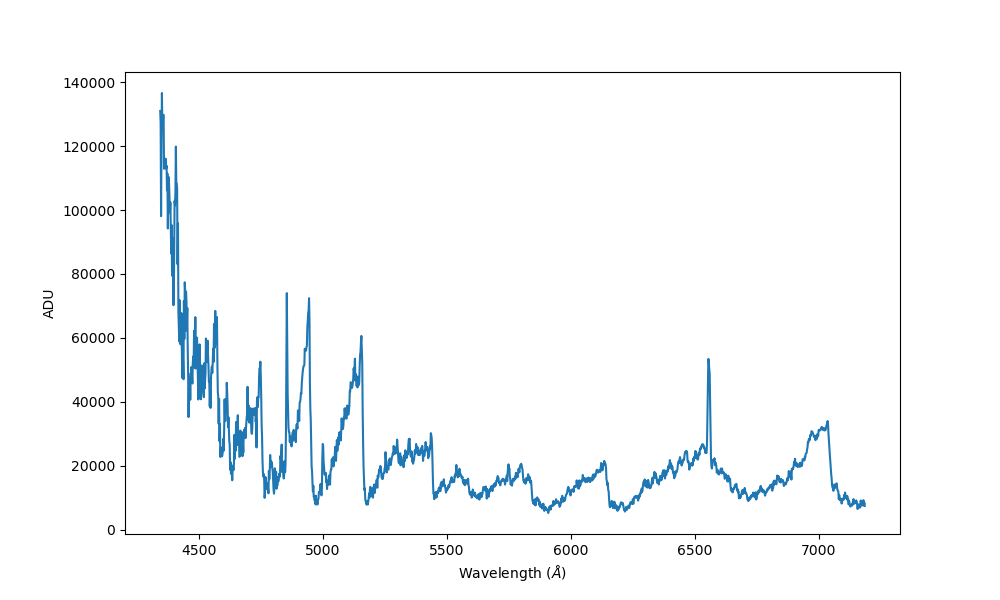

In [154]:
logger.info('calibrating science spectra...')
sci_calibrated_spectrum = cal.apply_to_spectrum(sci_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.plot(sci_calibrated_spectrum.wavelength, sci_calibrated_spectrum.flux) #, linewidth = '0.6');


### Spectrum smooth (optional)

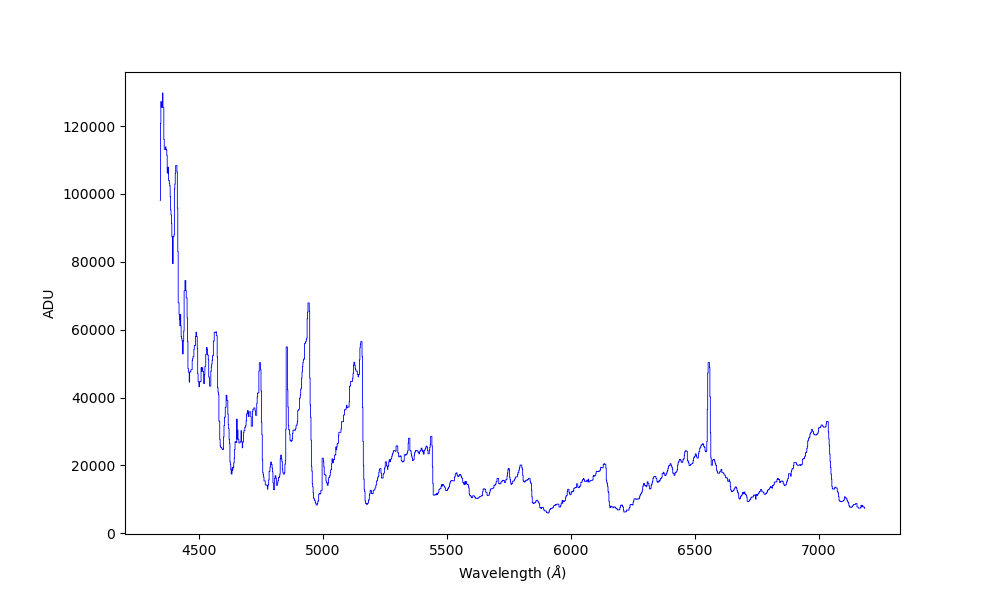

In [155]:
from specutils.manipulation import median_smooth, gaussian_smooth

smooth_spec = median_smooth(sci_calibrated_spectrum, width=5) 

plt.figure(figsize=(10,6))
#plt.xlim(3000, 9000)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.step(smooth_spec.wavelength, smooth_spec.flux, linewidth = '0.6', where="mid", color = 'b', label = 'science star');

### decide to keep the median smoothed version ?
#sci_calibrated_spectrum = smooth_spec

### Correct instrument response & airmass

In [157]:
from astropy.coordinates import get_sun, AltAz, EarthLocation
from astropy.coordinates import SpectralCoord, SkyCoord
from astropy.time import Time

### compute zenith distance (if not present in fit header)
#TARGET = 'ch cyg'
target_coord = SkyCoord.from_name(TARGET)
target_time = Time(master_science.header['DATE-OBS'])
obs_coord = EarthLocation(lon = OBS_LONGITUDE * u.deg, lat = OBS_LATITUDE * u.deg)
altaz = AltAz(obstime=target_time, location = obs_coord)

ZD = target_coord.transform_to(AltAz(obstime = target_time, location = obs_coord)).zen
airmass = 1.0 / np.cos(ZD)
logger.info(f'computed ZD={ZD}, airmass={airmass}')


2024-07-25 21:43:23 [INFO] - computed ZD=24.523710148978324 deg, airmass=1.0991552519307488


2024-07-25 21:39:58 [INFO] - reusing existing response file ... 
2024-07-25 21:39:58 [INFO] - response applied
4343.458795871202 1.7553174875950364


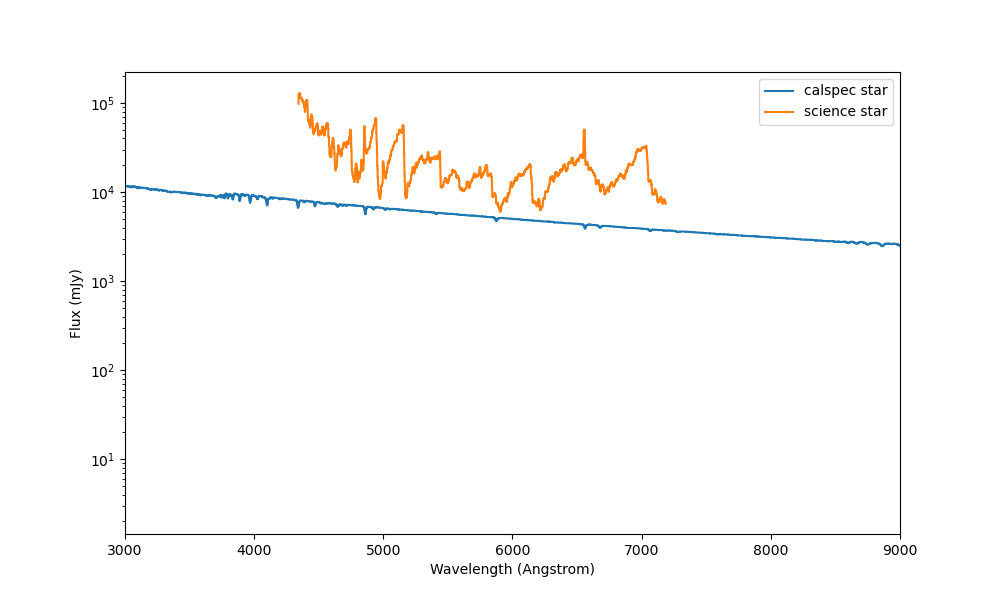

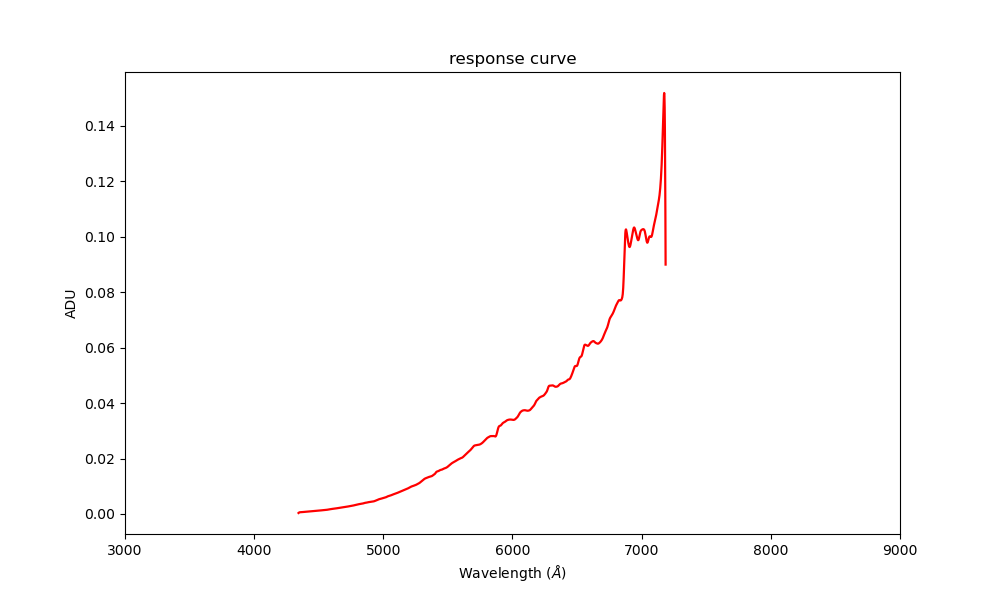

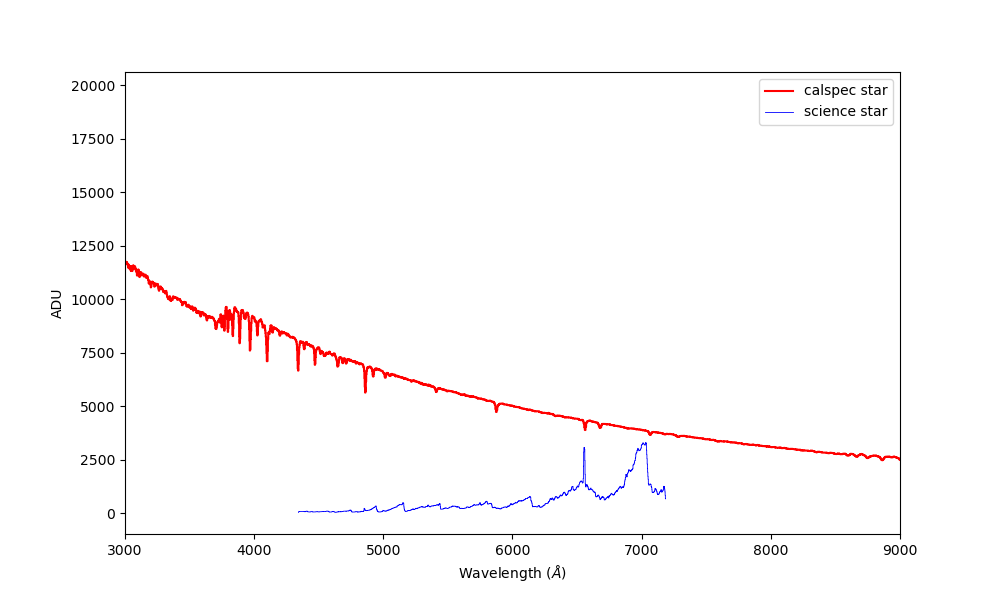

In [146]:
import matplotlib.pyplot as plt
from specreduce.calibration_data import load_MAST_calspec, load_onedstds
from specutils import Spectrum1D, SpectralRegion
from astropy.nddata import StdDevUncertainty
from specreduce.fluxcal import FluxCalibration
from specutils.manipulation import extract_region, gaussian_smooth, convolution_smooth, median_smooth
from astropy.coordinates import SpectralCoord, SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.convolution import Box1DKernel
from astropy.modeling import models, fitting
from specutils.fitting import fit_generic_continuum
import astropy.wcs as fitswcs
import astropy.io.fits as pyfits

from astropy.table import Table
from specutils.io.registers import custom_writer

### load proper reference star from CALSPEC database according to spectral type

#std_spec = load_onedstds(dataset = 'spec50cal', specfile = 'hd217086.dat')
#std_spec = load_onedstds(dataset = 'bstdscal', specfile = 'hr5511.dat')
#std_spec = load_MAST_calspec("delumi_stis_004.fits")
std_spec = load_MAST_calspec("hd93521_stis_007.fits")

#std_spec = load_MAST_calspec("bd60d1753_stiswfc_004.fits")

#std_slice = std_spec[3800*u.AA:8200*u.AA]
#sci_slice = sci_calibrated_spectrum[3800*u.AA:8200*u.AA]

std_slice = std_spec
sci_slice = sci_calibrated_spectrum


fig, ax = plt.subplots(figsize=(10,6))
plt.xlim(3000, 9000)
ax.step(std_slice.spectral_axis, std_slice.flux, label = 'calspec star') #, where="mid"
ax.step(sci_slice.spectral_axis, sci_slice.flux, label = 'science star') # where="mid", 
ax.set_yscale('log')
ax.set_xlabel(f"Wavelength ({std_slice.spectral_axis.unit})")
ax.set_ylabel(f"Flux ({std_slice.flux.unit})");
plt.legend(loc=('best'))

obj_spectrum = Spectrum1D(spectral_axis = sci_slice.spectral_axis, flux = sci_slice.flux)
sci_spectrum = FluxCalibration(obj_spectrum, airmass = airmass) 

'''
        mode : str, optional
            Can be "linear", "spline", or "poly" (Default is linear).
        polydeg : float, optional
            if mode='poly', this is the order of the polynomial to fit through.
            (Default is 9.)
'''
                
### reuse response file if exists
#if False:
if os.path.exists(CAPTURE_DIR + 'masterresponse.fit'):
    logger.info('reusing existing response file ... ')
    with fits.open(CAPTURE_DIR + 'masterresponse.fit') as file:
        specdata = file[1].data
        header = file[1].header
        responsefunc = Spectrum1D(flux = specdata['flux']* u.mJy, spectral_axis = specdata['wavelength'] * u.AA)
        
        final_spec = sci_spectrum.apply_sensfunc(responsefunc)
    logger.info('response applied')
else:
    logger.info('creating a new response file ...')
    responsefunc = sci_spectrum.standard_sensfunc(
        standard = std_slice,
        mode = 'linear', #'linear', # 'poly', #'spline', 
        polydeg = 1,
        #badlines=[7516, 6880, 6844, 6860, 6920, 6563, 4861, 4341],
        display = False)
    logger.info('response created')

    ### smooth the response func ?
    #smooth_response = gaussian_smooth(responsefunc, stddev=3) 
    #responsefunc = smooth_response
    #logger.info('response smoothed')
        
    final_spec = sci_spectrum.apply_sensfunc(responsefunc)
    logger.info('response applied')

    responsefunc.write(CAPTURE_DIR + 'masterresponse.fit', overwrite = True)

final_spec.write(CAPTURE_DIR + TARGET + '-1D.fit', overwrite = True)

#final_spec.write(CAPTURE_DIR + TARGET + '-1D-complete.fit', overwrite = True)

## Update sci file
#scihead = fits.open(CAPTURE_DIR + TARGET + '-1D.fit')
scihead = fits.open(CAPTURE_DIR + TARGET + '-reduced.fit')
hdr = scihead[0].header

### DEBUG ### 
hdr['SIMPLE']  = 'T'
hdr['BITPIX']  = -32 
hdr['NAXIS']   = 1 
del hdr['NAXIS2']

crval1 = final_spec.wavelength[0].value
cdelt1 = ((final_spec.wavelength[-1] - final_spec.wavelength[0]) / len(final_spec.wavelength)).value
print (crval1, cdelt1)

hdr['CRVAL1']  = crval1
hdr['CDELT1']  = cdelt1
hdr['OBJNAME'] = hdr['OBJECT'] 

### TO COMPUTE !
#hdr['BSS_ITRP'] = 670
#hdr['SPE_RPOW'] = 670
#hdr['EXPTIME2'] = '2 x 60s'
#hdr['JD-OBS']  = '2460502.47465'

hdr['CRPIX1']  = 1
hdr['CTYPE1']  = 'Wavelength' #'Linear'
hdr['CUNIT1']  = 'Angstrom'
hdr['VERSION'] = 'EasyAstro - ' + __version__ 
fits.writeto(CAPTURE_DIR + TARGET + '-1D-final.fit', final_spec.data, header = hdr, overwrite=True)

plt.figure(figsize=(10,6))
plt.xlim(3000, 9000)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.plot(responsefunc.wavelength, responsefunc.flux, linewidth = '1.6', color = 'r');
plt.title('response curve')


plt.figure(figsize=(10,6))
plt.xlim(3000, 9000)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
#plt.step(obj_spectrum.wavelength, obj_spectrum.flux, linewidth = '0.6', color = 'black');
plt.step(std_slice.spectral_axis, std_slice.flux, color = 'r', label = 'calspec star') #, where="mid", 
plt.step(final_spec.wavelength, final_spec.flux, linewidth = '0.6', color = 'b', label = 'science star'); #, where="mid",
plt.legend(loc=('best'))
#plt.step(std_spec.wavelength, std_spec.flux + 5000 * u.mJy, linewidth = '0.6', color = 'r')




## Analyse spectrum

### Show known lines

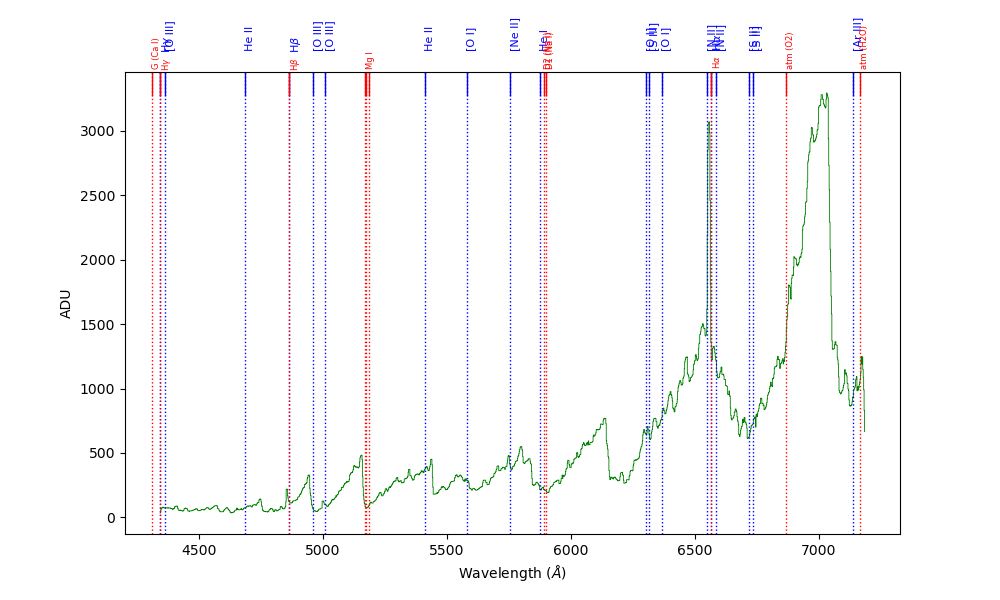

In [158]:
from spec_utils import show_lines
plt.figure(figsize = (10,6))
plt.step(final_spec.wavelength, final_spec.flux, color='green', linewidth = '0.6', where="mid")
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
#plt.ylim(-10000, 1e6)

show_lines(z = 0.0, ax = None, em_label = True, abs_label = True, rest_frame = True)


### Measure SNR

In [159]:
from specutils.fitting import fit_generic_continuum, fit_continuum
from specutils import SpectralRegion
from astropy.modeling import models, fitting
from specutils.analysis import snr, snr_derived
from specutils import Spectrum1D
from specutils.spectra import SpectralRegion
from specutils.manipulation import extract_region

with fits.open(CAPTURE_DIR + TARGET + '-1D.fit') as file:
    specdata = file[1].data
    header = file[1].header
    final_spec1d = Spectrum1D(flux = specdata['flux'] * u.mJy, spectral_axis = specdata['wavelength'] * u.AA)

print(f'snr = {snr_derived(final_spec1d)}')

FileNotFoundError: [Errno 2] No such file or directory: '../../../CAPTURES/OHP2024/20240710/ch cyg-1D.fit'

### Remove continuum

2024-07-25 21:31:45 [WARNING] - Model is linear in parameters; consider using linear fitting methods.


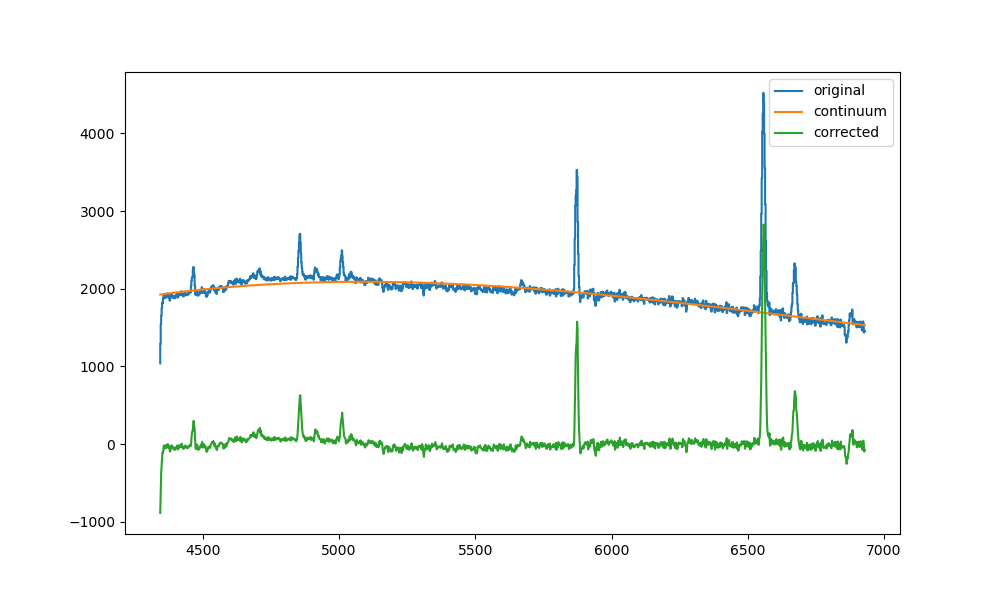

In [114]:
### extract continuum on a selected region

region = SpectralRegion(3800*u.AA, 6930*u.AA)

sub_spectra = extract_region(final_spec1d, region)

generic_continuum = fit_generic_continuum(sub_spectra, exclude_regions = [
        SpectralRegion(3700 * u.AA, 4000 * u.AA),
         SpectralRegion(4825 * u.AA, 4885 * u.AA),
         SpectralRegion(4825 * u.AA, 5200 * u.AA),
         SpectralRegion(6400 * u.AA, 6800 * u.AA)
        ])
#generic_continuum = fit_continuum(sub_spectra, models.Hermite1D(3))

generic_continuum_evaluated = generic_continuum(sub_spectra.spectral_axis)

spec_normalized = sub_spectra - generic_continuum_evaluated

plt.figure(figsize = (10,6))
plt.step(sub_spectra.spectral_axis, sub_spectra.flux)
plt.plot(sub_spectra.spectral_axis, generic_continuum_evaluated)
plt.plot(spec_normalized.spectral_axis, spec_normalized.flux)
plt.legend(['original', 'continuum', 'corrected'], loc=('best'))
#plt.xlim(4700, 5000)



### Identify lines

In [115]:
### identify lines
from specutils.fitting import find_lines_derivative
from specutils.fitting import fit_lines

lines = find_lines_derivative(spec_normalized, flux_threshold=200)
print('\nemission: \n', lines[lines['line_type'] == 'emission']) 
print('\nabsorption: \n', lines[lines['line_type'] == 'absorption']) 



emission: 
    line_center     line_type line_center_index
     Angstrom                                 
------------------ --------- -----------------
 4464.585436299949  emission                71
 4855.776187465026  emission               299
 5009.396875362615  emission               388
 5873.220817803068  emission               883
 6557.906591451132  emission              1269
6672.3677777626435  emission              1333

absorption: 
   line_center    line_type  line_center_index
    Angstrom                                 
---------------- ---------- -----------------
6862.53111689105 absorption              1439


### Fit a line

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean             stddev     
           mJy             Angstrom          Angstrom    
    ----------------- ----------------- -----------------
    587.2535849882802 4856.541872008752 5.443854205073068


(4811.0, 4911.0)

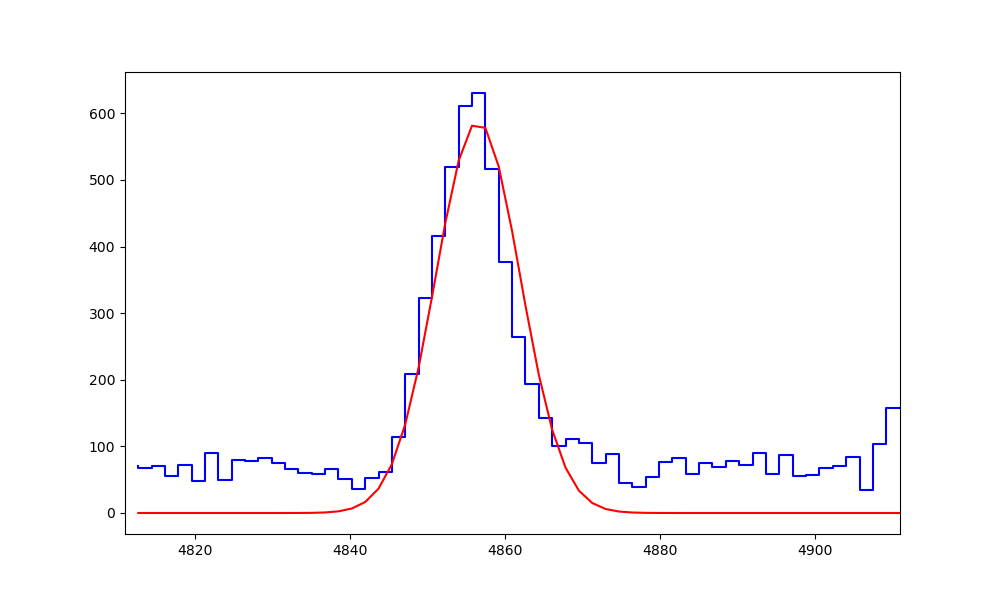

In [116]:
from specutils.manipulation import extract_region
from specutils.fitting import estimate_line_parameters
from specutils.analysis import centroid, fwhm
from specutils.fitting import fit_lines

#lineAA = 5016
#lineAA = 6563
lineAA = 4861

sr =  SpectralRegion((lineAA-50)*u.AA, (lineAA+50)*u.AA)
#sr =  SpectralRegion((lineAA-50)*u.AA, (lineAA+50)*u.AA)

#create a new spectrum of the selected region for plot
sub_spectrum = extract_region(spec_normalized, sr)
a_line = Spectrum1D(flux = sub_spectrum.flux, spectral_axis = sub_spectrum.spectral_axis)

line_estimate = models.Gaussian1D(mean = lineAA*u.AA, stddev = 7*u.AA, amplitude=45000)
line_model = fit_lines(sub_spectrum, line_estimate)
evaluated_model = line_model(sub_spectrum.wavelength)

print(line_model)

plt.figure(figsize = (10,6))
#plt.step(reg_spectra.wavelength, reg_spectra.flux, label="Original spectrum")
plt.step(a_line.spectral_axis, a_line.flux , label="original spectrum", color = 'b')
plt.plot(a_line.spectral_axis, evaluated_model , label="Fit result", color = 'r')
#plt.plot(a_line.spectral_axis, a_line.flux)
plt.xlim(lineAA-50, lineAA+50)


### Measure line

In [117]:
### measure 
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width
from specutils.analysis import gaussian_sigma_width, gaussian_fwhm, fwhm, fwzi


print(f'gaussian fwhm = {gaussian_fwhm(a_line)}' )
center = centroid(spec_normalized, sr)  
print(f'center = {center}')

print(f'fwhm = {fwhm(a_line)}') 
print(f'R = {(center / fwhm(a_line))}')
#print(f'fwzi = {fwzi(a_line)}') 

print(f'line flux = {line_flux(a_line)}'  )

#noisy_gaussian_with_continuum = noisy_gaussian + 1*u.Jy
print(f'equivalent width = {equivalent_width(a_line)}')


gaussian fwhm = 51.80772959326566 Angstrom
center = 4860.427634996709 Angstrom
fwhm = 11.408853408958748 Angstrom
R = 426.0224459699062
line flux = 13106.30556556883 Angstrom mJy
equivalent width = -13006.348133283009 Angstrom
